## Gradient Boosting
RFE→SMOTE→StratifiedKFold→GridSearchCV→Cross-Validation

Model used the following features:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'MaritalStatus', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Occupation_Large Business', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding']
Fitting 20 folds for each of 24 candidates, totalling 480 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation AUC: 0.9778
Cross-Validation AUC Scores: [0.83216292 0.87429775 0.7738764  0.77598315 0.75912921 0.8125
 0.87289326 0.84550562 0.8223

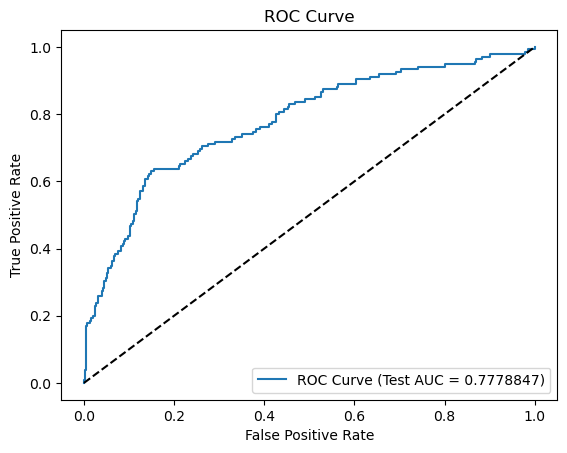

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/model/gradient_boosting_best0825_1.joblib に保存されました。
Precision: 0.5
Recall: 0.34814814814814815
F1 Score: 0.4104803493449782
Accuracy: 0.8494983277591973
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       762
     Class 1       0.50      0.35      0.41       135

    accuracy                           0.85       897
   macro avg       0.70      0.64      0.66       897
weighted avg       0.83      0.85      0.84       897



In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18, stratify=y)

# トレインデータの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train_clean = X_train.loc[train_indices]
y_train_clean = y_train.loc[train_indices]

# テストデータの前処理：nanを含む行を削除し、対応する y も削除
test_indices = X_test.dropna().index
X_test_clean = X_test.loc[test_indices]
y_test_clean = y_test.loc[test_indices]

# Gradient Boostingモデルのインスタンスを作成
gb_model = GradientBoostingClassifier(random_state=18)

# RFEを使用して重要な特徴量を選択
selector = RFE(gb_model, n_features_to_select=25)
selector.fit(X_train_clean, y_train_clean)

# 使用した特徴量をプリント
selected_feature_names = X_train_clean.columns[selector.support_]
print("Model used the following features:")
print(selected_feature_names.tolist())

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train_clean)
X_test_selected = selector.transform(X_test_clean)

# SMOTEを適用してクラス不均衡を解消
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train_clean)

# Gradient Boostingモデルのインスタンスを再作成
gb_model = GradientBoostingClassifier(random_state=18)

# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=18)

# グリッドサーチの設定
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
gb_grid_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
gb_best = gb_grid_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {gb_grid_search.best_score_:.4f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train_selected, y_train_clean, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test_clean, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test_clean, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gradient_boosting_best0825_1.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = gb_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test_clean, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test_clean, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test_clean, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test_clean, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test_clean, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## Gradient Boosting 
** RFE→SMOTE→StratifiedKFold→RandomSearch→CV

Selected features: Index(['NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'MaritalStatus', 'Age_ProdTaken_Mean',
       'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction',
       'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor',
       'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank',
       'TypeofContact_Company Invited', 'Occupation_Large Business',
       'Occupation_Small Business', 'Gender_Female',
       'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction',
       'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster',
       'Product_Designation_Target_Encoding'],
      dtype='object')
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.03, 'n_estimators': 50, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.002}
Best cross-validation AUC: 0.8195025
Cross-Validation 

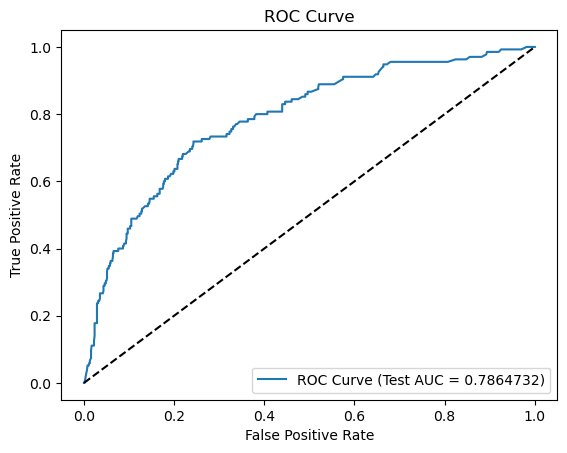

最適なGradientBoostingモデルが /Users/hayakawakazue/Downloads/signate/model/gb_best_model0829_2.joblib に保存されました。
Precision: 0.3672566371681416
Recall: 0.6148148148148148
F1 Score: 0.4598337950138504
Accuracy: 0.782608695652174
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.81      0.86       762
     Class 1       0.37      0.61      0.46       135

    accuracy                           0.78       897
   macro avg       0.64      0.71      0.66       897
weighted avg       0.84      0.78      0.80       897



In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# トレーニングデータの読み込み
train_data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0829_1.csv'
train_data = pd.read_csv(train_data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# 分布が一致しない特徴量を除外
features_to_exclude = ['DurationOfPitch_Category_Rank']
X_filtered = X.drop(columns=features_to_exclude)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=15, stratify=y)

# RFEを使用して重要な特徴量を選択
gb_model = GradientBoostingClassifier(random_state=15)  # モデルのインスタンスを作成
selector = RFE(gb_model, n_features_to_select=25)
selector.fit(X_train, y_train)

# 選択された特徴量のリストをプリント
selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# SMOTEを適用してクラス不均衡を解消
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Gradient Boostingモデルのインスタンスを再作成
gb_model = GradientBoostingClassifier(random_state=15)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [20, 50],
    'learning_rate': [0.001, 0.002],
    'max_depth': [1],
    'subsample': [0.02, 0.03],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [20, 25, 30, 35]
}

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

# ランダムサーチの設定
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=50, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=15)

# ランダムサーチの実行
gb_random_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
gb_best = gb_random_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_random_search.best_params_}")
print(f"Best cross-validation AUC: {gb_random_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train_smote, y_train_smote, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック(モデルがどれだけ汎化できるかを評価する)
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gb_best_model0829_2.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradientBoostingモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = gb_best.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, zero_division=0)

print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


## Gradient Boostingモデルが重視する特徴量を可視化する

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.05}
Best cross-validation AUC: 0.8200
Test AUC: 0.8077476426557791
Model's most important features (Top 30):
                                    Feature  Importance
21                         Designation_Rank    0.091198
9                             MonthlyIncome    0.082393
7                                  Passport    0.072487
36                 Designation_PropertyStar    0.063909
15                   CityTier_MonthlyIncome    0.063520
16                  MonthlyIncome_PerFamily    0.055044
13            Age_MonthlyIncome_Interaction    0.047163
17                           Income_Per_Age    0.041588
20                      ProductPitched_Rank    0.040358
37  CityTier_Age_Income_x_FamilySize_Income    0.036951
0                                       Age

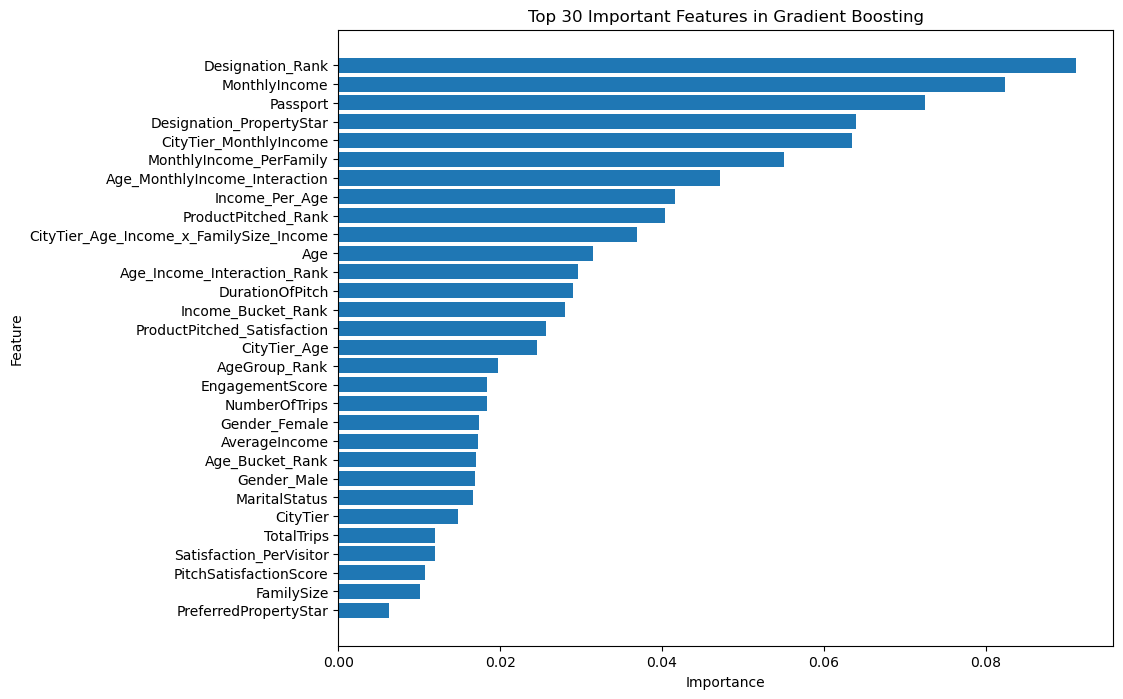

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

# GradientBoostingモデルの定義
gb_model = GradientBoostingClassifier(verbose=0, random_state=17)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]  # 'auto'を削除し、Noneを追加
}

# StratifiledKFoldの設定
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

# ランダムサーチの設定
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=10, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1, 
                                      random_state=17)

# トレーニングデータでランダムサーチを実行
gb_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_random_search.best_params_}")
print(f"Best cross-validation AUC: {gb_random_search.best_score_:.4f}")

# 最適なモデルを取得
gb_best = gb_random_search.best_estimator_

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 重要度の取得と上位30の特徴量を可視化
importance = gb_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(30)

# 重要な特徴量のリストを表示
print("Model's most important features (Top 30):")
print(importance_df)

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Important Features in Gradient Boosting')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## GradientBoost | Selected heatures SMOTE→pipeline→StratifiedKHold→GridSearch→cv

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500, 'subsample': 0.8}
Best cross-validation AUC: 0.9712
Test AUC: 0.7766321243523315
Cross-Validation AUC Scores: [0.86411069 0.99620685 0.99823448 0.99610783 0.99532137]
Mean Cross-Validation AUC: 0.9699962408968927
過学習の可能性があります: Cross-Validation AUCがTest AUCを0.1933641だけ上回っています。


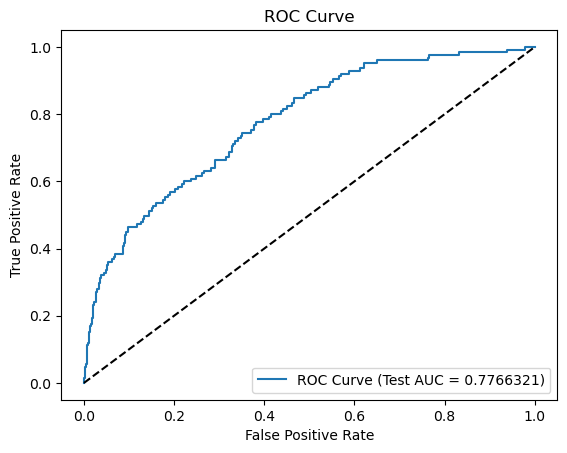

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/model/gradient_boosting_selectedFeatures0826_1.joblib に保存されました。
Precision: 0.47058823529411764
Recall: 0.384
F1 Score: 0.42290748898678415
Accuracy: 0.8539576365663322
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.92       772
     Class 1       0.47      0.38      0.42       125

    accuracy                           0.85       897
   macro avg       0.69      0.66      0.67       897
weighted avg       0.84      0.85      0.85       897



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Age_MonthlyIncome_Interaction', 'Designation_Rank',
    'Product_Designation_Target_Encoding', 'Age_ProdTaken_Mean', 'CityTier_Age_Income_Interaction', 
    'Passport', 'ProductPitched_Satisfaction', 'Income_Per_Age', 'FamilySize_Income_Interaction', 
    'Age_DurationOfPitch', 'Gender_Female', 'EngagementScore', 
    'NumberOfTrips', 'MaritalStatus', 'Income_ProdTaken_Mean', 'Satisfaction_PerVisitor', 
    'TypeofContact_Company Invited','Cluster_ProdTaken_Ratio', 'PreferredPropertyStar', 
    'DurationOfPitch_Category_Rank','Occupation_Large Business', 'NumberOfFollowups',
    'NumberOfPersonVisiting', 'Cluster', 'Occupation_Small Business', 'CarCount'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# SMOTEを適用して不均衡データを解消
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Gradient Boostingモデルの定義
gb_model = GradientBoostingClassifier(random_state=8)

# ハイパーパラメータの範囲を設定
param_grid = {
    'n_estimators': [100, 200, 300],  # 木の数を適度に設定
    'learning_rate': [0.01, 0.05],  # 学習率を小さく設定
    'max_depth': [2, 3],  # 木の深さを浅めに設定
    'subsample': [0.6, 0.8],  # サブサンプルを1.0より小さく設定
    'max_features': ['sqrt', 'log2'],
    'n_iter_no_change': [10]  # 早期終了を追加
}

# StratifiedKFoldを使用したクロスバリデーションの設定
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# グリッドサーチの設定
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=stratified_kfold, 
                              scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
gb_grid_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
gb_best = gb_grid_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {gb_grid_search.best_score_:.4f}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gradient_boosting_selectedFeatures0826_1.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = gb_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# Precisionを計算（zero_divisionを指定）
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
print(f"Precision: {precision}")

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


# 特徴量を選択しグリッドサーチでトレーニングする

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation AUC: 0.8134439
Cross-Validation AUC Scores: [0.83667737 0.80950704 0.82155153 0.81057456 0.78446233]
Mean Cross-Validation AUC: 0.8125545658470171
Test AUC: 0.8220812676193253
過学習の兆候は見られません。


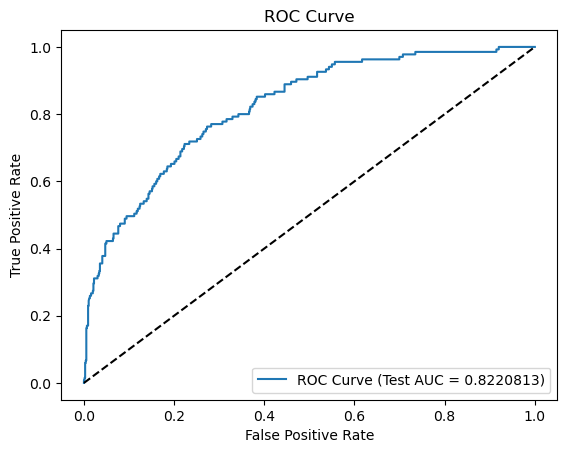

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/model/gradient_boosting0901_11.joblib に保存されました。


In [8]:
import pandas as pd
import numpy as np
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'MonthlyIncome', 'Passport', 
    'Designation_PropertyStar', 'CityTier_MonthlyIncome', 
    'MonthlyIncome_PerFamily', 'Age_MonthlyIncome_Interaction',
    'Income_Per_Age', 'ProductPitched_Rank', 'CityTier_Age_Income_x_FamilySize_Income', 'Age',
    'Age_Income_Interaction_Rank', 'DurationOfPitch', 'Income_Bucket_Rank', 'ProductPitched_Satisfaction', 
    'CityTier_Age', 'AgeGroup_Rank', 'EngagementScore', 'NumberOfTrips', 'Gender_Female'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# StratifiedKFoldを使用したクロスバリデーションの設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Gradient Boostingモデルの定義
gb_model = GradientBoostingClassifier(random_state=123)

# グリッドサーチの設定
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                              cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行（サンプルの重みを適用）
gb_grid_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {gb_grid_search.best_score_:.7f}")

# 最適なモデルを取得
gb_best = gb_grid_search.best_estimator_

# 最適なモデルを使用して再トレーニング
gb_best.fit(X_train, y_train, sample_weight=sample_weight)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gradient_boosting0901_11.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")


## 特徴量を選択し、ランダムサーチでトレーニングする

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 150, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.05}
Best cross-validation AUC: 0.8204418
Cross-Validation AUC Scores: [0.84858213 0.81751761 0.82709591 0.83854237 0.78086296]
Mean Cross-Validation AUC: 0.8225201929429259
Test AUC: 0.8311023622047246
過学習の兆候は見られません。


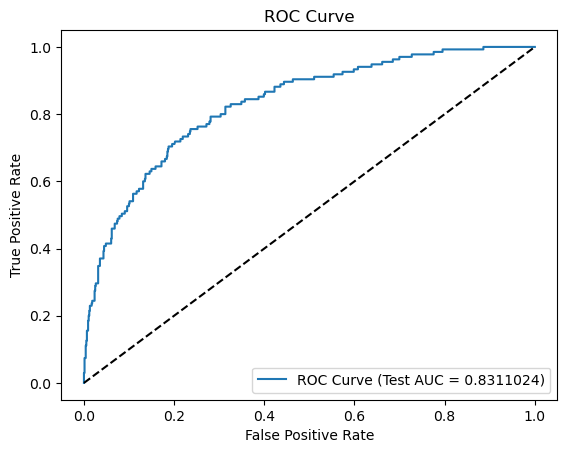

最適なGradient Boostingモデルが /Users/hayakawakazue/Downloads/signate/model/gradient_boosting0901_1.joblib に保存されました。


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt


# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'MonthlyIncome', 'Passport', 
    'Designation_PropertyStar', 'CityTier_MonthlyIncome', 
    'MonthlyIncome_PerFamily', 'Age_MonthlyIncome_Interaction',
    'Income_Per_Age', 'ProductPitched_Rank', 'CityTier_Age_Income_x_FamilySize_Income', 'Age',
    'Age_Income_Interaction_Rank', 'DurationOfPitch', 'Income_Bucket_Rank', 'ProductPitched_Satisfaction', 
    'CityTier_Age', 'AgeGroup_Rank', 'EngagementScore', 'NumberOfTrips', 'Gender_Female'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# StratifiedKFoldを使用したクロスバリデーションの設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# サンプルの重みを計算
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Gradient Boostingモデルの定義
gb_model = GradientBoostingClassifier(random_state=123)

# ランダムサーチの設定
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=50, cv=skf, scoring='roc_auc', n_jobs=-1, random_state=123, verbose=1)

# ランダムサーチの実行（サンプルの重みを適用）
gb_random_search.fit(X_train, y_train, sample_weight=sample_weight)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {gb_random_search.best_params_}")
print(f"Best cross-validation AUC: {gb_random_search.best_score_:.7f}")

# 最適なモデルを取得
gb_best = gb_random_search.best_estimator_

# 最適なモデルを使用して再トレーニング
gb_best.fit(X_train, y_train, sample_weight=sample_weight)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(gb_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'gradient_boosting0901_1.joblib')
joblib.dump(gb_best, model_path)
print(f"最適なGradient Boostingモデルが {model_path} に保存されました。")
